In [11]:
# Required Libraries
import torch
import numpy as np
import torch.nn as nn
from IPython import display
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch.nn.functional as F
from IPython.display import display
from matplotlib.ticker import MultipleLocator

### Mutual information neural estimation (MINE-Net)
In this notebook tou will calculate the ***mutual information (MI)*** between two different pairs of IRIS spectral lines using a neural network called a ***MINE-network***. This method was developed recently by [Belghazi et al 2018](http://proceedings.mlr.press/v80/belghazi18a/belghazi18a.pdf).

***Why calculate MI?:***
Two random variables can be correlated in a highly complex non-linear way. The normal covariance measure, only captures linear correlations. The MI between two random variables is given by

$$
M I(X ; Y)=\sum_{x} \sum_{y} p(x, y) \log \frac{p(x, y)}{p(x) p(y)},
$$


and is the KL-divergence (distance) between the joint probability distribution $p(x, y)$ and the product of the marginals $p(x) p(y)$. The latter tells us what the baseline uncorrelated distribution should look like, while the joint distribution is the actual probability distribution between the two variables. The more these two distributions differ, the higher the MI.

***How do we calculate the MI?***  

There exists a dual representation that allows us to parameterize the MI in terms of a neural network. The fancy part of the MINE-network is not its architecture, but rather how it samples the data. Notice that we take spectra from two different pixel locations. The upper half of the network takes spectra from line $\mathcal{L}1$ and $\mathcal{L}2$ from the same pixel, and therefore samples from the joint probability distribution $p(x, y)$. The lower half of the network takes spectra from different pixels, and therefore samples form the product of the marginals since we assume that the data in the two pixels are uncorrelated. The spectra in both the upper and lower channels are processed the same way. They are compressed by an encoder, concatenated, and then compressed again to a real number. We don’t impose any restrictions on how the network maps from complex raw spectral inputs to a single real number. We then ask the network to distinguish between the upper and lower channels by any means necessary. Since the lower channel samples from two random pixels, it is estimating the baseline uncorrelated state. Therefore, the only way the network can distinguish between the two channels is to learn all possible correlations that exist between the two lines sourced from the same pixels. The extent to which the network can separate the two real number outputs is proportional to the MI. In fact, it can be shown that the MI estimated in this way forms a tight lower bound on the actual MI.  

***Why should this network interest you?***
The MINE-network is compatible with any data type and can even measure the MI between two very different data types, e.g., images and spectra. It can be applied directly to the raw data, with no additional categorical transformations needed. The MI can be used as an important component in other more complex generative models such as InfoGANs. 

***Calculating the MI between different IRIS spectral lines during a flare***

Here, we calculate all the dependencies that exist between different pairs of IRIS spectral lines taken from a single solar flare, namely the <font color='#8dd8f8'>(Mg II | C II)</font> and  
<font color='#f6b270'>(Mg II | FeII)</font> line pairs. Since Mg II and C II have a similar formation height and atomic physics, we expect that the MI between them is much higher than that of the Mg II and Fe II line pair, which form in the chromosphere and photosphere respectively. 

In [12]:
# functions to transform the data
def transform1(data):
    # reshape data form (step, raster, y, lambda) to (i, lambda)
    data_transposed = np.transpose(data, (1,0,2,3))
    nprof = data_transposed.reshape( data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], order='C' )
    return nprof

def transform2(nprof1, nprof2, num_samples):
    # sample n random pixels containing spectra from line1 and line2
    inds = np.random.randint(nprof1.shape[0], size=num_samples)
    sub_nprof1 =  nprof1[inds, :]
    sub_nprof2 =  nprof2[inds, :]
    return sub_nprof1, sub_nprof2

def transform3(nprof1, nprof2):
    # remove pixel if either spectrum containing nan values
    inds1 = np.argwhere(~np.isnan(nprof1).any(axis=1) == False)
    inds2 = np.argwhere(~np.isnan(nprof2).any(axis=1) == False)
    inds = np.concatenate( (inds1, inds2) )
    inds = np.squeeze( np.unique( inds ) )
    clean_nprof1 = np.delete(nprof1, inds, axis=0)
    clean_nprof2 = np.delete(nprof2, inds, axis=0)
    return clean_nprof1, clean_nprof2

In [13]:
# Define the network in the figure using PyTorch
class MIEstimator1(nn.Module):
    def __init__(self, d1, d2, d_z):
        super(MIEstimator1, self).__init__()
        self.fc1 = nn.Linear(d1, d_z)
        self.fc2 = nn.Linear(d2, d_z)
        self.fc3 = nn.Linear(2 * d_z, d_z)
        self.fc4 = nn.Linear(d_z, 1)

    def forward(self, x, y):
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(y))  
        out = torch.cat((x, y), 2)
        out = F.relu(self.fc3(out))  
        out = self.fc4(out)
        return out

In [14]:
# data loader that generates samples of joints and marginals 
class MINEDataLoader(torch.utils.data.Dataset):
    def __init__(self, line1='MgII', line2='CII', num_samples=1000):
        self.num_samples = num_samples
        data1 = np.load('./data_models/xai3/'+line1+'_Spectra.npz')['data']
        data2 = np.load('./data_models/xai3/'+line2+'_Spectra.npz')['data']
        data1 = transform1( data1 )
        data2 = transform1( data2 )
        data1, data2 = transform2(data1, data2, num_samples)
        self.nprof1, self.nprof2 = transform3(data1, data2)
        
    def __len__(self):
        return (self.num_samples * 2)
    
    def __getitem__(self, indx):
        x_sample = torch.from_numpy(self.nprof1).type(torch.FloatTensor)
        y_sample = torch.from_numpy(self.nprof2).type(torch.FloatTensor)
        y_shuffle = torch.from_numpy(np.random.permutation(y_sample)).type(torch.FloatTensor)
        return x_sample, y_sample, y_shuffle

In [15]:
# Calculate the MI for Mg II and C II at each step of the networks training
dataloader = torch.utils.data.DataLoader(MINEDataLoader(line1='MgII', line2='CII'))
n_epoch = 100
x, y, y2 = next(iter(dataloader))
model = MIEstimator1(x.shape[2], y.shape[2], 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mi_hist1 = []
for epoch in range(n_epoch):
    x_sample, y_sample, y_shuffle = next(iter(dataloader))
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)
    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist1.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

In [16]:
# Calculate the MI for Mg II and Fe II at each step of the networks training
dataloader = torch.utils.data.DataLoader(MINEDataLoader(line1='MgII', line2='FeII'))
n_epoch = 100
x, y, y2 = next(iter(dataloader))
model = MIEstimator1(x.shape[2], y.shape[2], 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mi_hist2 = []
for epoch in range(n_epoch):
    x_sample, y_sample, y_shuffle = next(iter(dataloader))
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)
    loss = - (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
    mi_hist2.append(-1 * loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

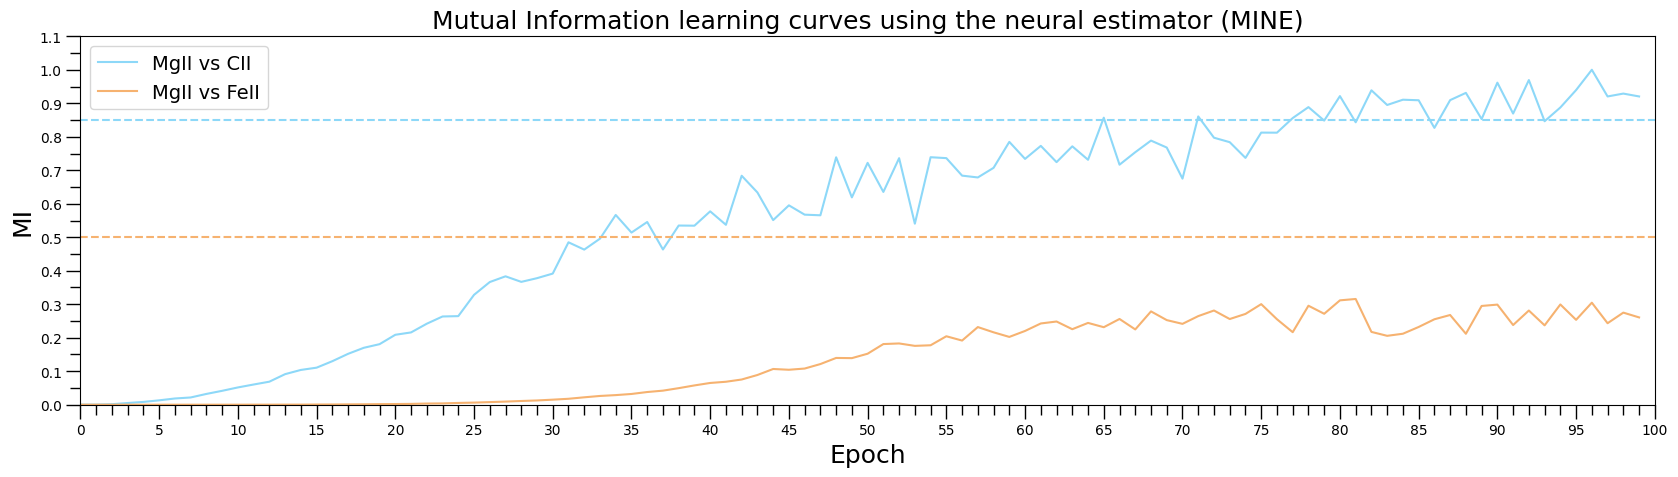

In [17]:
# Plot results
fig, ax = plt.subplots(figsize=(17,5))
rcParams['font.size'] = 14
plt.title('Mutual Information learning curves using the neural estimator (MINE)', fontsize=18)
plt.plot(range(0, n_epoch), mi_hist1, c='#8dd8f8', label='MgII vs CII')
plt.plot(range(0, n_epoch), mi_hist2, c='#f6b270', label='MgII vs FeII')
plt.axhline(.85, c='#8dd8f8', linestyle='--')
plt.axhline(.5, c='#f6b270', linestyle='--')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='major', length=10,width=1)
ax.tick_params(which='minor', length=7,width=1)
plt.legend()
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('MI', fontsize=18)
plt.xlim(0,100)
plt.ylim(0,1.1)
plt.tight_layout()
plt.show()
plt.close(fig)